In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.figure as figure
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from networkx import radius
%matplotlib widget



# Set matplotlib configurations
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.size'] = 12.
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['text.usetex'] = False 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite

def read_swc(file_path):
    data = np.loadtxt(file_path)
    return data

def plot_swc_to_svg(swc_data, svg_file_path):
    fig, ax = plt.subplots()
    for i, line in enumerate(swc_data):
        if line[6] != -1:
            parent_idx = int(line[6] - 1)
            x = [swc_data[parent_idx][2], line[2]]
            y = [swc_data[parent_idx][3], line[3]]
            z = [swc_data[parent_idx][4], line[4]]
            ax.plot(x, y, z, color='black')

    ax.set_aspect('equal')
    ax.axis('off')

    plt.savefig('temp_plot.svg')
    plt.close(fig)

    # Convert the saved plot to SVG
    with open('temp_plot.svg', 'r') as temp_svg:
        svg_content = temp_svg.read()
    with open(svg_file_path, 'w') as svg_file:
        svg_file.write(svg_content)


# swc_file_path = '/Volumes/MILSTEINLAB/07042024_imaging_conf/20240522/20240522_Neuronslice1-stiched3x2-004.swc'
# svg_file_path = '/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Sholl_Analysis/05162024_c1_WT_Neuron.svg'
# swc_data = read_swc(swc_file_path)
# plot_swc_to_svg(swc_data, svg_file_path)



In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def pull_and_process_data(folder_path):
    # Get all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Initialize lists to hold all the data for mean/SEM calculation
    all_radius_data = []
    all_intersection_data = []
    
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        data = pd.read_csv(file_path)
        
        # Assume 'Radius' and 'Inters.' are the columns of interest
        radius_data = data['Radius']
        intersection_data = data['Inters.']
        
        # # Check if 'basal' is in the filename and make radius negative
        # if 'basal' in csv_file.lower():
        #     radius_data = -radius_data
        # 
        all_radius_data.extend(radius_data)
        all_intersection_data.extend(intersection_data)
    
    return np.array(all_radius_data), np.array(all_intersection_data)

def calculate_mean_sem(radius_data, intersection_data):
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({'Radius': radius_data, 'Inters.': intersection_data})
    
    # Group by 'Radius' and aggregate 'Inters.'
    grouped = df.groupby('Radius')['Inters.'].apply(list)
    
    # Calculate mean and SEM for each radius point
    means = []
    sems = []
    radii = []
    
    for radius, inters in grouped.items():
        radii.append(radius)
        if len(inters) > 1:  # Ensure there is more than one data point
            means.append(np.mean(inters))
            sems.append(sem(inters) / np.sqrt(len(inters))) 
        else:
            # Handle cases with insufficient data points
            means.append(np.nan)
            sems.append(np.nan)
    
    return np.array(radii), np.array(means), np.array(sems)

def plot_mean_fit_line(radius_data, intersection_data, ax, color='blue', alpha=0.7, fit_label='Mean Fit'):
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({'Radius': radius_data, 'Inters.': intersection_data})
    
    # Group by 'Radius' and aggregate 'Inters.'
    grouped = df.groupby('Radius')['Inters.'].apply(list)
    
    # Calculate mean for each radius point
    means = []
    radii = []
    
    for radius, inters in grouped.items():
        radii.append(radius)
        if len(inters) > 0:
            means.append(np.mean(inters))
        else:
            means.append(np.nan)
    
    radii = np.array(radii)
    means = np.array(means)
    
    # Fit polynomial to mean data
    z = np.polyfit(radii[~np.isnan(means)], means[~np.isnan(means)], 15)  # Avoid NaNs in fitting
    p = np.poly1d(z)
    
    # Plot the mean fit line
    ax.plot(radii, p(radii), color=color, alpha=alpha, linewidth=2, label=fit_label)

def plot_sholl_from_folder(folder_path, figure=None, colors={'mean': 'blue', 'fit': 'red'}, 
                           mean_label='Mean ± SEM', fit_label='Mean Fit'):
    # Pull and process data from folder
    radius_data, intersection_data = pull_and_process_data(folder_path)
    
    # Calculate mean and SEM
    radii, means, sems = calculate_mean_sem(radius_data, intersection_data)
    
    # Use provided figure or create a new one
    if figure is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        ax = figure.axes[0]
    
    # Plot mean and SEM
    ax.errorbar(radii, means, yerr=sems, fmt='o', color=colors['mean'], capsize=5, label=mean_label)
    
    #plot the means
    # ax.plot(radii, means, color=colors['mean'], alpha=0.7)
    
    # # Plot the mean fit line
    plot_mean_fit_line(radius_data, intersection_data, ax, color=colors['fit'], fit_label=fit_label) 


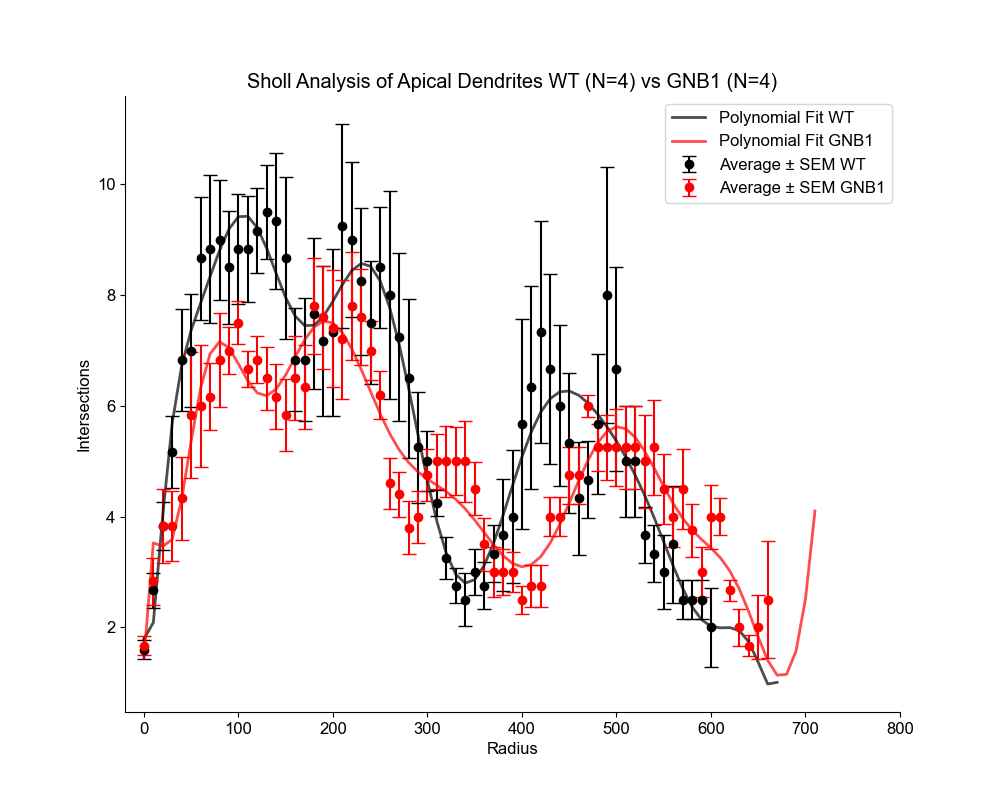

In [25]:

WT_dir_path = '/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/WT'
GNB1_dir_path = '/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/GNB1'

# Example usage
fig, ax = plt.subplots(figsize=(10, 8))

plot_sholl_from_folder(WT_dir_path, 
    figure=fig, 
    colors={'mean': 'black', 'fit': 'black'},
    mean_label='Average ± SEM WT',
    fit_label='Polynomial Fit WT')

plot_sholl_from_folder(GNB1_dir_path,
    figure=fig,
    colors={'mean': 'red', 'fit': 'red'},
    mean_label='Average ± SEM GNB1',
    fit_label='Polynomial Fit GNB1')

# Customize and show plot
ax.set_xlabel('Radius')
ax.set_ylabel('Intersections')
ax.set_title('Sholl Analysis of Apical Dendrites WT (N=4) vs GNB1 (N=4)')
ax.set_xticks(np.arange(-200, 850, 100))
#get rid of the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

ax.set_xlim(-20, 800)

plt.show()
    


In [103]:
import matplotlib.patches as patches 

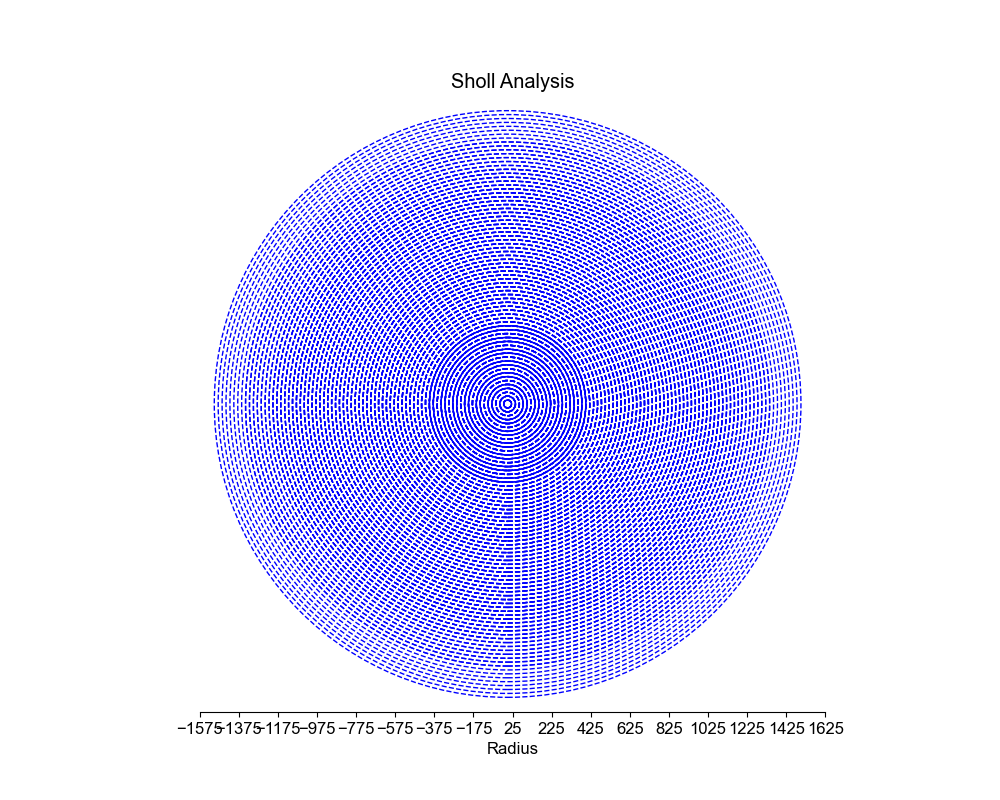

In [131]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

def plot_sholl_circles_only(folder_path, fig=None, ax=None, circle_color='green', radius_scale=1.5, tick_interval=200):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Pull and process data from folder
    radius_data, _ = pull_and_process_data(folder_path)
    
    # Apply scaling factor to radius data
    scaled_radius_data = [r * radius_scale for r in radius_data]
    
    # Calculate the range for x and y axes
    max_radius = max(scaled_radius_data)
    min_radius = min(scaled_radius_data)
    
    # Set x and y limits to include all scaled data and ensure circles fit
    buffer = 0.05 * max_radius  # Small buffer for better fit
    ax.set_xlim(left=-max_radius - buffer, right=max_radius + buffer)
    ax.set_ylim(bottom=-max_radius - buffer, top=max_radius + buffer)
    
    # Draw circles for Sholl analysis
    for radius in scaled_radius_data:
        circle = patches.Circle((0, 0), radius, color=circle_color, fill=False, linestyle='--', linewidth=1)
        ax.add_patch(circle)
    
    # Set x-ticks with specified interval and remove y-ticks
    tick_positions = np.arange(-max_radius - buffer, max_radius + buffer + tick_interval, tick_interval)
    ax.set_xticks(tick_positions)
    ax.set_yticks([])  # Remove y-ticks
    
    # Remove y-axis and spines
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Make sure circles are displayed correctly
    ax.set_aspect('equal')  # Ensures circles are proportional

    return scaled_radius_data

# Example usage
fig, ax = plt.subplots(figsize=(10, 8))
radius_data = plot_sholl_circles_only(WT_dir_path, fig=fig, ax=ax, circle_color='blue', radius_scale=2, tick_interval=200)

ax.set_xlabel('Radius')
ax.set_title('Sholl Analysis')

plt.show()

# #save as svg
# plt.savefig('Sholl_Analysis.svg', format='svg')  


In [ ]:
## Plotting Circles around radius points 

array([ 2.,  4.,  8., 11., 15., 17., 18., 22., 18., 17., 16., 16., 14.,
       11.,  8.,  4.,  2.,  2.,  2.,  2.,  1.,  3.,  4.,  4.,  4.,  5.,
        5.,  9.,  6.,  7.,  8.,  8., 10., 11., 16., 23., 26., 17., 20.,
       24., 23., 25., 20., 17., 16., 14., 15., 19., 16., 15., 11.,  8.,
        5.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  3.,  4.,  4.,  5.,  5.,
        5.,  5.,  8.,  7.,  6.,  6.,  6.,  6.,  5.,  5.,  5.,  5.,  4.,
        3.,  1.,  3.,  3.,  3.,  3.,  3.,  4.,  6.,  8.,  8.,  8.,  7.,
        7.,  7., 10., 16., 13.,  8.,  8.,  4.,  3.,  3.,  2.,  2.,  2.,
        2.,  1.,  5.,  5.,  7.,  9., 10., 12., 12., 13., 12., 15., 13.,
       12., 12., 10.,  8.,  6.,  4.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  3.,  2.,  4.,  3.,  5.,  5.,  4.,  3.,  3.,
        4.,  5.,  4.,  4.,  4.,  4.,  4.,  4.,  6.,  2.,  2.,  3.,  2.,
        3.,  3.,  4.,  3.,  3.,  3.,  2.,  2.,  1.,  1.,  1.,  1

In [3]:
# #WT Cells
# 
# # import data CSV files 05162024
# Apical_Dendrites_05162024 = pd.read_csv('/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/Sholl_Table_Apical_05162024.csv')
# Basal_Dendrites_05162024 = pd.read_csv('/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/Sholl_Table_Basal_05162024.csv')
# 
# # 0522024
# # Apical_Dendrites_summary = pd.read_csv('/Volumes/MILSTEINLAB/07042024_imaging_conf/20240522/Apical_Properties_05222024.csv')
# Apical_Dendrites_05222024 = pd.read_csv('/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/Sholl_Table-Apical_05222024_c1.csv')
# Basal_Dendrites_05222024 = pd.read_csv('/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/Sholl_Table-Basal_05222024_c1.csv')  
# 
# # 05302024
# Apical_Dendrites_05232024 = pd.read_csv('/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/Sholl_Table-Apical_05232024.csv')
# 
# #07092024
# Apical_Dendrites_07092024 = pd.read_csv('/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/Sholl_Table-Apical_07092024_Slice_1_Cell_1.csv')
# 
# #07172024
# Apical_Dendrites_07172024 = pd.read_csv('/Users/samgritz/Library/CloudStorage/GoogleDrive-gritz122@gmail.com/My Drive/Rutgers/Milstein_Lab_Data/GNB1_WT_Project/New_Analysis_Processed_Data/Reconstruction_data/Sholl_analysis_data/Sholl_Table-Apical_07172024_Slice_1_Cell_1.csv')
# 
# 
# # GNB1 Cells
# # 07232024 Cell 1
# Apical_Dendrites_07232024_Cell_1 = pd.read_csv('/Volumes/MILSTEINLAB/07312024_Imaging_conf/07312024_Neuron_GNB1_and_WT/GNB1_Cells/Sholl_Table-Apical_Cell_1_Left.csv')
# 
# # 07232024 Cell 2
# Apical_Dendrites_07232024_Cell_2 = pd.read_csv('/Volumes/MILSTEINLAB/07312024_Imaging_conf/07312024_Neuron_GNB1_and_WT/GNB1_Cells/Sholl_Table-Apical_Cell_2_Right.csv')
# 
# 
# 
# 


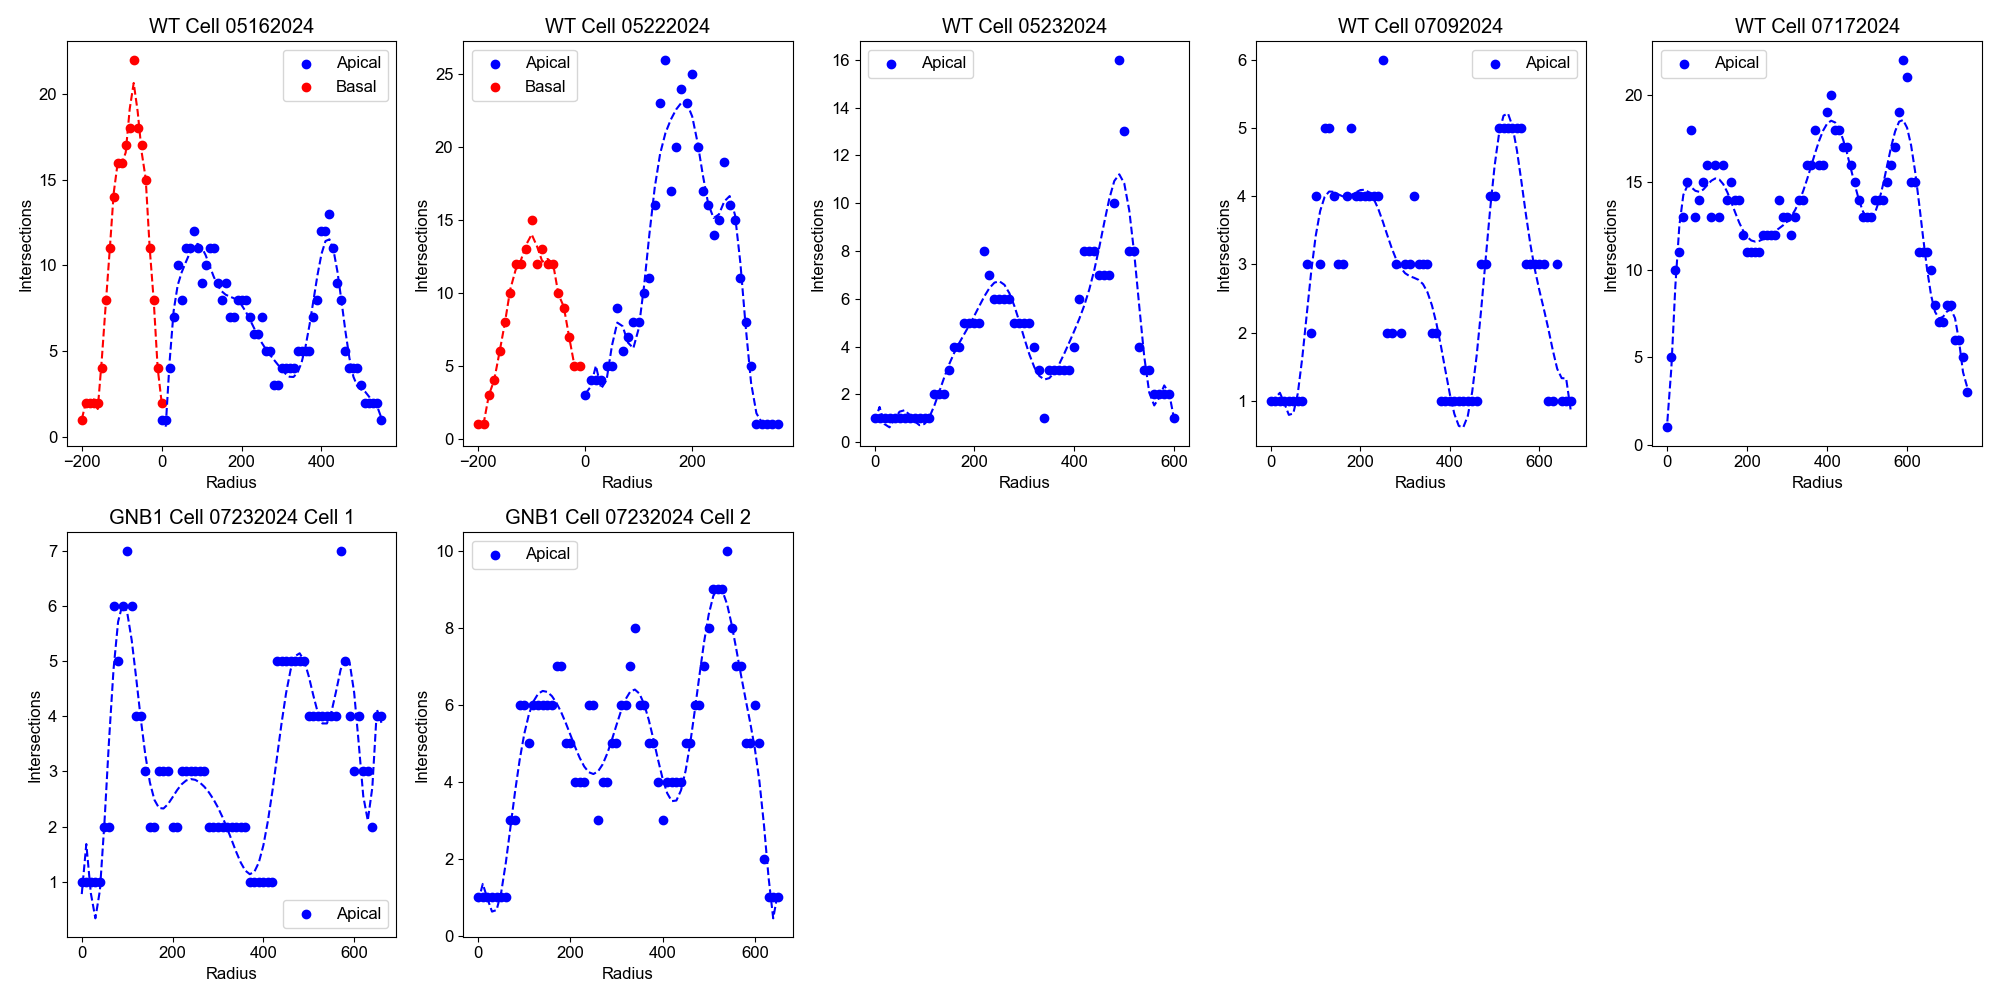

In [4]:
# # plotting WT 
# fig, ax = plt.subplots(2, 5, figsize=(20, 10))
# plot_sholl_data(Apical_Dendrites_05162024['Radius'], Apical_Dendrites_05162024['Inters.'], ax[0,0], 'Apical', 'blue')
# plot_sholl_data(-Basal_Dendrites_05162024['Radius'], Basal_Dendrites_05162024['Inters.'], ax[0,0], 'Basal', 'red')
# ax[0,0].set_xlabel('Radius')
# ax[0,0].set_ylabel('Intersections')
# ax[0,0].set_title('WT Cell 05162024')
# ax[0,0].legend()
# 
# plot_sholl_data(Apical_Dendrites_05222024['Radius'], Apical_Dendrites_05222024['Inters.'], ax[0, 1], 'Apical', 'blue')
# plot_sholl_data(-Basal_Dendrites_05222024['Radius'], Basal_Dendrites_05222024['Inters.'], ax[0, 1], 'Basal', 'red')
# ax[0,1].set_xlabel('Radius')
# ax[0,1].set_ylabel('Intersections')
# ax[0,1].set_title('WT Cell 05222024')
# ax[0,1].legend()
# 
# plot_sholl_data(Apical_Dendrites_05232024['Radius'], Apical_Dendrites_05232024['Inters.'], ax[0, 2], 'Apical', 'blue')
# ax[0,2].set_xlabel('Radius')
# ax[0,2].set_ylabel('Intersections')
# ax[0,2].set_title('WT Cell 05232024')
# ax[0,2].legend()
# 
# plot_sholl_data(Apical_Dendrites_07092024['Radius'], Apical_Dendrites_07092024['Inters.'], ax[0, 3], 'Apical', 'blue')
# ax[0,3].set_xlabel('Radius')
# ax[0,3].set_ylabel('Intersections')
# ax[0,3].set_title('WT Cell 07092024')
# ax[0,3].legend()
# 
# plot_sholl_data(Apical_Dendrites_07172024['Radius'], Apical_Dendrites_07172024['Inters.'], ax[0, 4], 'Apical', 'blue')
# ax[0,4].set_xlabel('Radius')
# ax[0,4].set_ylabel('Intersections')
# ax[0,4].set_title('WT Cell 07172024')
# ax[0,4].legend()
# 
# # plotting GNB1
# plot_sholl_data(Apical_Dendrites_07232024_Cell_1['Radius'], Apical_Dendrites_07232024_Cell_1['Inters.'], ax[1, 0], 'Apical', 'blue')
# ax[1,0].set_xlabel('Radius')
# ax[1,0].set_ylabel('Intersections')
# ax[1,0].set_title('GNB1 Cell 07232024 Cell 1')
# ax[1,0].legend()
# 
# plot_sholl_data(Apical_Dendrites_07232024_Cell_2['Radius'], Apical_Dendrites_07232024_Cell_2['Inters.'], ax[1, 1], 'Apical', 'blue')
# ax[1,1].set_xlabel('Radius')
# ax[1,1].set_ylabel('Intersections')
# ax[1,1].set_title('GNB1 Cell 07232024 Cell 2')
# ax[1,1].legend()
# 
# #clear the [1:, 2:] axis
# for i in range(1, 2):
#     for j in range(2, 5):
#         ax[i, j].axis('off')
# 
# fig.tight_layout()

In [ ]:
#close all the figures
plt.close('all')